In [143]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from tqdm.notebook import tqdm
import torchcde
from scipy.signal import find_peaks

In [2]:
with h5py.File('/work/hmzhao/irregular-lc/KMT-test.h5', mode='r') as dataset_file:
    Y = torch.tensor(dataset_file['Y'][...])
    X = torch.tensor(dataset_file['X'][...])

# filter nan
nanind = torch.where(~torch.isnan(X[:, 0, 1]))[0]
Y = Y[nanind]
X = X[nanind]

Y[:, 3:6] = torch.log10(Y[:, 3:6])
Y[:, -1] = torch.log10(Y[:, -1])
Y[:, 6] = Y[:, 6] / 180
Y = Y[:, 2:]
print('Shape of Y: ', Y.shape)

X[:, :, 1] = (X[:, :, 1] - 14.5 - 2.5 * Y[:, [-1]]) / 0.2
print(f'normalized X mean: {torch.mean(X[:, :, 1])}\nX std: {torch.mean(torch.std(X[:, :, 1], axis=0))}')

X = X[:, :, :2]
    
# CDE interpolation with log_sig
depth = 3; window_length = 5
logsig = torchcde.logsig_windows(X, depth, window_length=window_length)
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

Shape of Y:  torch.Size([100000, 6])
normalized X mean: -1.1794236895673196
X std: 1.0507553336706146


In [3]:
from model.cde_mdn import CDE_MDN

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/cde_mdn/experiment_2.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

output_dim = Y.shape[-1]
input_dim = logsig.shape[-1]
latent_dim = ckpt_args.latents

model = CDE_MDN(input_dim, latent_dim, output_dim).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

CDE_MDN(
  (cde_func): CDEFunc(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (relu1): PReLU(num_parameters=1)
    (resblocks): Sequential(
      (0): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (relu2): PReLU(num_parameters=1)
    (linear2): Linear(in_features=1024, out_features=160, bias=True)
    (tanh): Tanh()
    (linear3): Linear(in_features=

In [4]:
num = 64
batchsize = 64
n_gaussian = model.n_gaussian
pis = torch.zeros((num, n_gaussian))
locs = torch.zeros((num, n_gaussian, output_dim))
scales = torch.zeros((num, n_gaussian, output_dim))
model.eval()
for i in tqdm(range(int(np.ceil(num / batchsize)))):
    batch = coeffs[i*batchsize:min(i*batchsize+batchsize, num)].float().to(device)
    pi, normal = model(batch)
    pis[i*batchsize:min(i*batchsize+batchsize, num)] = pi.probs.detach().cpu()
    locs[i*batchsize:min(i*batchsize+batchsize, num)] = normal.loc.detach().cpu()
    scales[i*batchsize:min(i*batchsize+batchsize, num)] = normal.scale.detach().cpu()

  0%|          | 0/1 [00:00<?, ?it/s]

In [139]:
def get_loglik(pi, loc, scale, x, margin_dim, exp=False):
    shape = x.shape
    loc = loc[..., margin_dim]
    scale = scale[..., margin_dim]
    normal = torch.distributions.Normal(loc, scale)
    x = x.reshape(-1, loc.shape[0], 1).tile(1, loc.shape[-1])
    loglik = normal.log_prob(x).reshape(*shape[:-1], -1)
    loglik = torch.logsumexp(torch.log(pi) + loglik, dim=-1)
    if exp:
        return torch.exp(loglik)
    return loglik

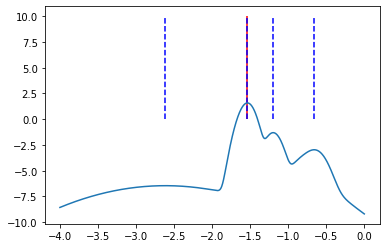

In [162]:
i = 6
qlist = torch.linspace(-4, 0, 1000).reshape(-1, 1, 1).tile(1, num, 1)
plt.plot(np.linspace(-4, 0, 1000), get_loglik(pis, locs, scales, qlist, margin_dim=2, exp=False)[:, i])
peaks = find_peaks(get_loglik(pis, locs, scales, qlist, margin_dim=2, exp=False).transpose(1, 0)[i])[0]
plt.vlines(Y[i, 2], 0, 10, color='red')
plt.vlines(np.linspace(-4, 0, 1000)[peaks], 0, 10, color='blue', linestyles='dashed')